In [1]:
from DataFetcher import DataFetcher
from USTs import USTs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

In [2]:
auctions = DataFetcher().fetch_auction_data()
prices = DataFetcher().fetch_historical_UST_data(date=datetime.datetime(year=2025, month=6, day=23))

In [3]:
ust_set = USTs(auction_data=auctions, price_data=prices)
ust_set = ust_set.get_current_UST_set(as_of_date=datetime.date(2025, 6, 24),
                                      get_ytms=True, include_FRNs=False, include_TIPS=False)

Merged auction and price data successfully
No missing or excess data
All CUSIPs are identical between DataFrames


In [4]:
ust_set

,Cusip,Security type,Rate,Maturity date,Buy,Sell,End of day,security_term,issue_date,YTM
0,912797PT8,Bill,0.000,2025-06-24,0.000000,99.988361,100.000000,17-Week,2025-02-25,0.000000
1,912797NW3,Bill,0.000,2025-06-26,0.000000,99.965667,99.977556,26-Week,2024-12-26,0.045000
2,912797PU5,Bill,0.000,2025-07-01,99.908778,99.908667,99.920667,17-Week,2025-03-04,0.243000
3,912797NX1,Bill,0.000,2025-07-03,99.885833,99.885556,99.897000,26-Week,2025-01-02,0.207000
4,912797PZ4,Bill,0.000,2025-07-08,99.828750,99.828333,99.840167,17-Week,2025-03-11,0.490000
...,...,...,...,...,...,...,...,...,...,...
392,912810UA4,Bond,4.625,2054-05-15,96.187500,96.156250,95.812500,30-Year,2024-05-15,4.900472
393,912810UC0,Bond,4.250,2054-08-15,90.421875,90.406250,90.062500,30-Year,2024-08-15,4.896929
394,912810UE6,Bond,4.500,2054-11-15,94.390625,94.375000,94.000000,30-Year,2024-11-15,4.889572
395,912810UG1,Bond,4.625,2055-02-15,96.437500,96.406250,96.062500,30-Year,2025-02-18,4.880857


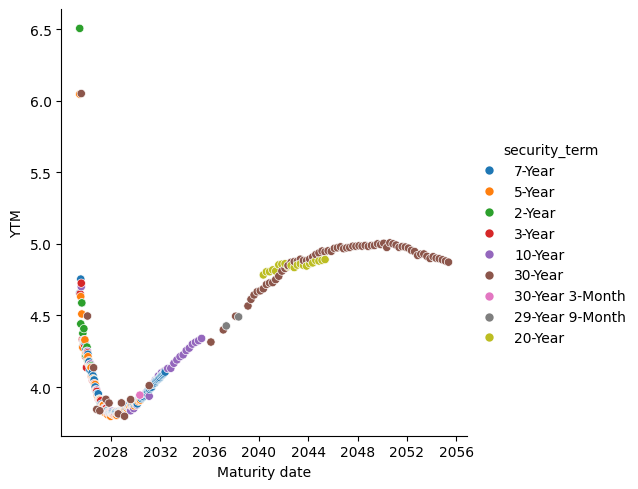

In [8]:
filtered_data = ust_set[ust_set['Security type'] != 'Bill']
sns.relplot(data=filtered_data, x='Maturity date', y='YTM', kind='scatter', hue='security_term')